In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import glob
import librosa
import librosa.display
import datasets.dcase_few_shot_bioacoustic as util

import matplotlib.pyplot as plt

import IPython.display as ipd

# README
This is a notebook for sound event prediction audiation. Audiation is to hearing what visualization is to vision. This tool is useful if you want to browse through the sound events in a prediciton / annotation .csv file of the type:

    filname, start-time, end-time, class
    <filename>.wav, <start-second>, <end-second>, <event-class>

In [2]:
ls '/home/willbo/data/dcase/val'

a1.csv                    BUK4_20161011_000804.csv   BUK5_20180921_015906a.csv
a1.wav                    BUK4_20161011_000804.wav   BUK5_20180921_015906a.wav
BUK1_20181011_001004.csv  BUK4_20171022_004304a.csv  n1.csv
BUK1_20181011_001004.wav  BUK4_20171022_004304a.wav  n1.wav
BUK1_20181013_023504.csv  BUK5_20161101_002104a.csv
BUK1_20181013_023504.wav  BUK5_20161101_002104a.wav


In [6]:
root_path = '/home/willbo/data/dcase/val/'
filename = 'BUK4_20161011_000804'

annotation_file_path = os.path.join(root_path, filename) + '.csv'
audio_file_path = os.path.join(root_path, filename) + '.wav'
print(annotation_file_path)
print(audio_file_path)

/home/willbo/data/dcase/val/BUK4_20161011_000804.csv
/home/willbo/data/dcase/val/BUK4_20161011_000804.wav


In [4]:
def select_events_with_value(data_frame, value='POS'):
    indices = data_frame.index[data_frame['class'] == value].tolist()
    return indices

def build_matrix_from_selected_rows(data_frame, selected_indices):
    matrix_data = np.ones((2, len(selected_indices)))* -1
    for n, idx in enumerate(selected_indices):
        matrix_data[0, n] = data_frame.loc[idx]['start-time']
        matrix_data[1, n] = data_frame.loc[idx]['end-time']
    return matrix_data

def load_prediction_dataframe(prediction_file_path, annotation_file_path, filename):
    prediction_dataframe = pd.read_csv(prediction_file_path)
    prediction_dataframe['class'] = 'POS'
    prediction_dataframe.columns = ['filename', 'start-time', 'end-time', 'class']
    predicted_events_by_audiofile = dict(tuple(prediction_dataframe.groupby('filename')))
    prediction_dataframe = predicted_events_by_audiofile[filename + '.wav']
    
    annotation_dataframe = load_annotation_dataframe(annotation_file_path)
    
    ref_pos_indices = select_events_with_value(annotation_dataframe, value='POS')
    pred_pos_indices = select_events_with_value(prediction_dataframe, value='POS')

    ref_1st_round = build_matrix_from_selected_rows(annotation_dataframe, ref_pos_indices)
    pred_1st_round = build_matrix_from_selected_rows(prediction_dataframe, pred_pos_indices)

    m_pos = util.match_events(ref_1st_round, pred_1st_round, min_iou=0.3)
    tp_indices = np.array([x[1] for x in m_pos])
    for i, (index, row) in enumerate(prediction_dataframe.iterrows()):
        if i in tp_indices:
            prediction_dataframe.at[index, 'class'] = 'TP'
        else:
            prediction_dataframe.at[index, 'class'] = 'FP'
    
    return prediction_dataframe

def load_annotation_dataframe(file_path):
    annotation_dataframe = pd.read_csv(file_path)
    annotation_dataframe.columns = ['filename', 'start-time', 'end-time', 'class']
    
    return annotation_dataframe

In [7]:
prediction_file_path = 'predictions/rbigg7seg03/PP_BEST_VAL_out.csv'
prediction_df = load_prediction_dataframe(prediction_file_path, annotation_file_path, filename)
prediction_df[:5]

,filename,start-time,end-time,class
75,BUK4_20161011_000804.wav,371.728333,371.774750,FP
76,BUK4_20161011_000804.wav,371.867583,372.006917,FP
77,BUK4_20161011_000804.wav,372.053333,372.146250,FP
78,BUK4_20161011_000804.wav,373.307250,373.400167,FP
79,BUK4_20161011_000804.wav,410.366333,410.412750,FP


In [8]:
annotation_df = load_annotation_dataframe(annotation_file_path)
annotation_df[:5]

,filename,start-time,end-time,class
0,BUK4_20161011_000804.wav,91.446324,91.465685,POS
1,BUK4_20161011_000804.wav,105.023503,105.063170,POS
2,BUK4_20161011_000804.wav,169.152942,169.170442,POS
3,BUK4_20161011_000804.wav,204.470003,204.496626,POS
4,BUK4_20161011_000804.wav,264.650134,264.664366,POS


In [26]:
def play_first_audio_events(audio_file_path, annotation_df, event_class, n=5, expand=0):
    audio, sample_rate = librosa.load(audio_file_path, None)
    print(sample_rate)
    event_df = annotation_df[annotation_df['class'] == event_class][:n]
    audio_objects = []
    for index, row in event_df.iterrows():
        start_time = float(row['start-time'])
        end_time   = float(row['end-time'])
        
        start_idx = int((start_time-expand)*sample_rate)
        end_idx = int((end_time+expand)*sample_rate)
        
        if start_idx < 0:
            start_idx = 0
        if end_idx > len(audio):
            end_idx = len(audio)
        
        audio_segment = audio[start_idx:end_idx]
        audio_object = ipd.Audio(audio_segment, rate=sample_rate)
        ipd.display(audio_object)
        
def get_first_audio_events(audio_file_path, annotation_df, event_class, n=5, expand=0):
    audio, sample_rate = librosa.load(audio_file_path, None)
    print(sample_rate)
    event_df = annotation_df[annotation_df['class'] == event_class][:n]
    audio_segments = []
    for index, row in event_df.iterrows():
        start_time = float(row['start-time'])
        end_time   = float(row['end-time'])
        
        start_idx = int((start_time-expand)*sample_rate)
        end_idx = int((end_time+expand)*sample_rate)
        
        if start_idx < 0:
            start_idx = 0
        if end_idx > len(audio):
            end_idx = len(audio)
        
        audio_segment = audio[start_idx:end_idx]
        audio_segments.append(audio_segment)
    return audio_segments
        
def play_random_audio_events(audio_file_path, annotation_df, event_class, n=5, expand=0):
    audio, sample_rate = librosa.load(audio_file_path, None)
    event_df = annotation_df[annotation_df['class'] == event_class][:n]
    audio_objects = []
    audio_segments = []
    for index, row in event_df.iterrows():
        start_time = float(row['start-time'])
        end_time   = float(row['end-time'])
        
        start_idx = int((start_time-expand)*sample_rate)
        end_idx = int((end_time+expand)*sample_rate)
        
        if start_idx < 0:
            start_idx = 0
        if end_idx > len(audio):
            end_idx = len(audio)
        
        audio_segment = audio[start_idx:end_idx]
        audio_segments.append(audio_segment)

    if n > len(audio_segments):
        n = len(audio_segments)
    
    random_choice_indices = np.random.choice(np.arange(n), n, replace=False)

    for idx in random_choice_indices:
        audio_object = ipd.Audio(audio_segments[idx], rate=sample_rate)
        ipd.display(audio_object)
    
    return [audio_segments[idx] for idx in random_choice_indices]

In [17]:
play_first_audio_events(audio_file_path, annotation_df, event_class='POS', n=10, expand=0.2)

44100


44100


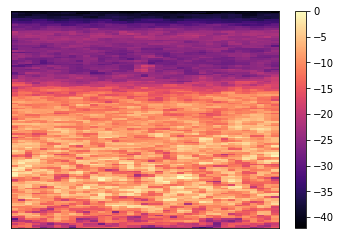

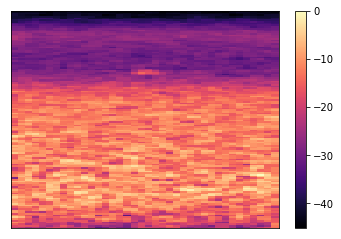

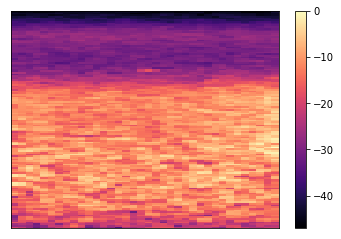

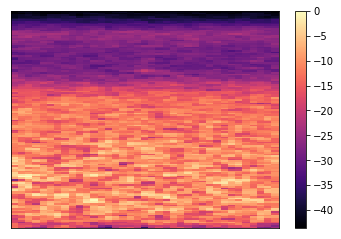

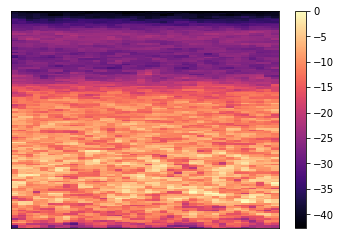

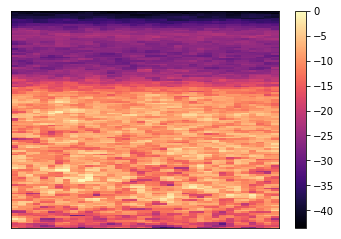

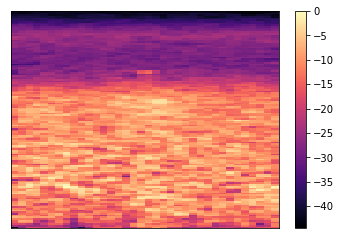

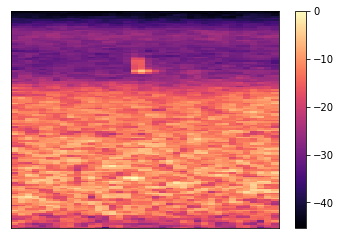

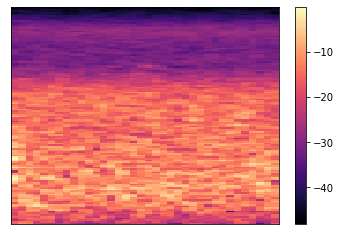

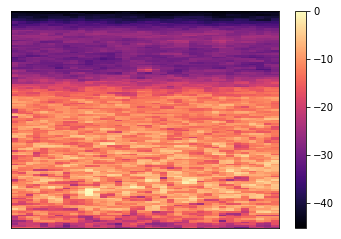

In [16]:
audio_segments = get_first_audio_events(audio_file_path, annotation_df, event_class='POS', n=10, expand=0.2)
for audio_segment in audio_segments:
    D = librosa.stft(audio_segment)  # STFT of y
    D = librosa.feature.melspectrogram(audio_segment, sr=44100)
    S_db = librosa.power_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

In [18]:
play_random_audio_events(audio_file_path, prediction_df, event_class='TP', n=5, expand=0.2)

In [34]:
segments = play_random_audio_events(audio_file_path, prediction_df, event_class='FP', n=10, expand=0.5)

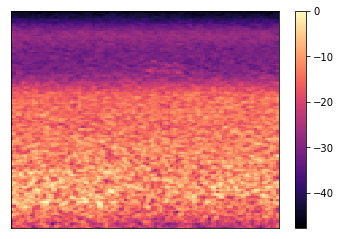

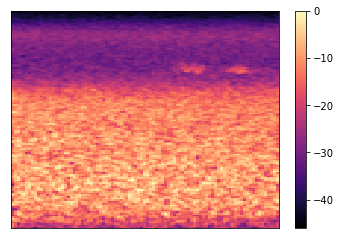

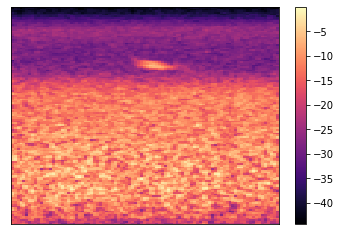

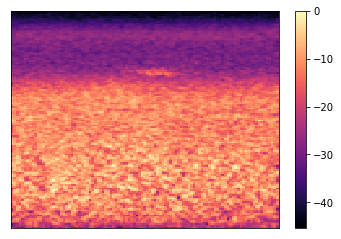

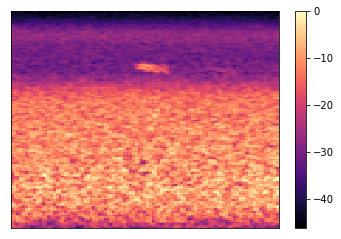

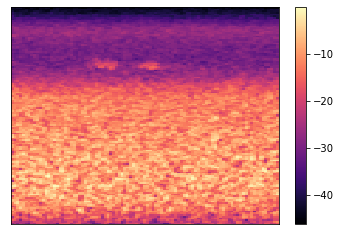

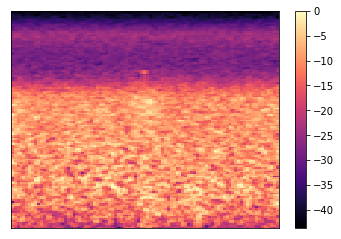

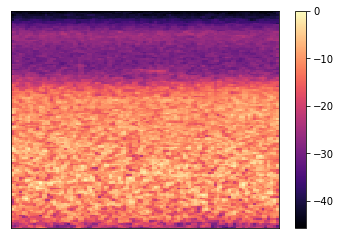

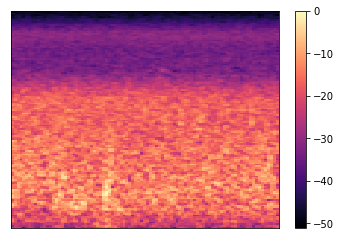

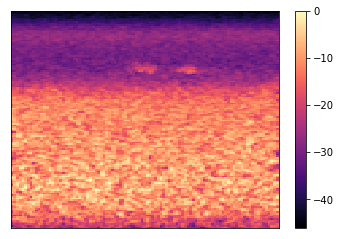

In [35]:
for audio_segment in segments:
    D = librosa.stft(audio_segment)  # STFT of y
    D = librosa.feature.melspectrogram(audio_segment, sr=44100)
    S_db = librosa.power_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

In [39]:
segments = play_random_audio_events(audio_file_path, prediction_df, event_class='FN', n=5, expand=0.4)

In [ ]:
for audio_segment in segments:
    D = librosa.stft(audio_segment)  # STFT of y
    D = librosa.feature.melspectrogram(audio_segment, sr=44100)
    S_db = librosa.power_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

In [ ]:
print(audio_file_path)
audio, sample_rate = librosa.load(audio_file_path, None)
ipd.Audio(audio[:sample_rate*100], rate=sample_rate)